In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", font_scale=1.05)
plt.rcParams['figure.dpi'] = 100

# Output folder
os.makedirs('/content/outputs', exist_ok=True)


In [ ]:
traders = pd.read_csv('/content/historical_data.csv')
sentiment = pd.read_csv('/content/fear_greed_index.csv')

print("Traders shape:", traders.shape)
print("Sentiment shape:", sentiment.shape)

# See columns to adapt mapping
print("\nTraders columns:\n", traders.columns.tolist())
print("\nSentiment columns:\n", sentiment.columns.tolist())

# Peek
display(traders.head())
display(sentiment.head())


Traders shape: (41760, 16)
Sentiment shape: (2644, 4)

Traders columns:
 ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Sentiment columns:
 ['timestamp', 'value', 'classification', 'date']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,895000000000000.0,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,443000000000000.0,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,660000000000000.0,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1080000000000000.0,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1050000000000000.0,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
def normalize_cols(df):
    df = df.copy()
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(r'\s+', '_', regex=True)
          .str.replace(r'[^\w_]', '', regex=True)
    )
    return df

traders = normalize_cols(traders)
sentiment = normalize_cols(sentiment)

print("Normalized traders columns:", traders.columns.tolist())
print("Normalized sentiment columns:", sentiment.columns.tolist())


Normalized traders columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Normalized sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [ ]:
# Try common timestamp names
possible_trader_ts = ['timestamp_ist', 'timestamp', 'time', 'datetime']
for c in possible_trader_ts:
    if c in traders.columns:
        traders['timestamp'] = pd.to_datetime(traders[c], errors='coerce')
        print("Using trader timestamp column:", c)
        break

# sentiment date: common column names
possible_sent_date = ['date', 'day', 'timestamp']
for c in possible_sent_date:
    if c in sentiment.columns:
        sentiment['sent_date'] = pd.to_datetime(sentiment[c], errors='coerce')
        print("Using sentiment date column:", c)
        break

# Extract date-only (no time) for merging
traders['date'] = traders['timestamp'].dt.date
sentiment['date'] = sentiment['sent_date'].dt.date

# Drop rows with no date
traders.dropna(subset=['date'], inplace=True)
sentiment.dropna(subset=['date'], inplace=True)

print("Trader date range:", traders['timestamp'].min(), "to", traders['timestamp'].max())
print("Sentiment date range:", sentiment['sent_date'].min(), "to", sentiment['sent_date'].max())


Using trader timestamp column: timestamp_ist
Using sentiment date column: date
Trader date range: 2023-05-12 03:11:00 to 2025-12-04 23:55:00
Sentiment date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


In [ ]:
# Common names mapping
rename_map = {
    'execution_price': 'execution_price',
    'executionprice': 'execution_price',
    'exec_price': 'execution_price',
    'size': 'size_tokens',
    'size_tokens': 'size_tokens',
    'closedpnl': 'closed_pnl',
    'closed_pnl': 'closed_pnl',
    'closed_pnl_usd': 'closed_pnl',
    'leverage': 'leverage'
}
# Apply mapping where column exists
existing_renames = {k:v for k,v in rename_map.items() if k in traders.columns}
traders.rename(columns=existing_renames, inplace=True)

# Coerce numeric columns safely
for col in ['execution_price', 'size_tokens', 'closed_pnl', 'leverage']:
    if col in traders.columns:
        traders[col] = pd.to_numeric(traders[col], errors='coerce')
        print(f"Converted {col} to numeric")


Converted execution_price to numeric
Converted size_tokens to numeric
Converted closed_pnl to numeric


In [ ]:
# find likely classification column in sentiment/merged
possible_class_cols = ['classification','class','sentiment','fear_greed','classification_type']
sent_col = None
for c in possible_class_cols:
    if c in sentiment.columns:
        sent_col = c
        break

if sent_col:
    sentiment['classification'] = sentiment[sent_col].astype(str).str.strip().str.title()
    print("Using sentiment classification column:", sent_col)
else:
    print("No obvious sentiment classification column found in sentiment df. Available:", sentiment.columns.tolist())


Using sentiment classification column: classification


In [ ]:
merged = pd.merge(
    traders,
    sentiment[['date','classification']].drop_duplicates(),
    on='date',
    how='left'
)

print("Merged shape:", merged.shape)
display(merged[['date','timestamp','classification']].head(10))


Merged shape: (14893, 18)


,date,timestamp,classification
0,2024-02-12,2024-02-12 22:50:00,Greed
1,2024-02-12,2024-02-12 22:50:00,Greed
2,2024-02-12,2024-02-12 22:50:00,Greed
3,2024-02-12,2024-02-12 22:50:00,Greed
4,2024-02-12,2024-02-12 22:50:00,Greed
5,2024-02-12,2024-02-12 22:50:00,Greed
6,2024-02-12,2024-02-12 22:50:00,Greed
7,2024-02-12,2024-02-12 22:50:00,Greed
8,2024-02-12,2024-02-12 22:50:00,Greed
9,2024-02-12,2024-02-12 22:50:00,Greed


In [ ]:
print(traders.columns)



Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'date', 'position_value'],
      dtype='object')


In [ ]:
print(traders[['position_value', 'start_position', 'leverage']].head())

merged = pd.merge(
    traders,
    sentiment[['date', 'classification']].drop_duplicates(),
    on='date',
    how='left'
)



   position_value  start_position  leverage
1      127.680000      986.524596  0.129424
2     1150.630695     1002.518996  1.147740
3     1142.038452     1146.558564  0.996058
4       69.747462     1289.488521  0.054089
5       11.265900     1298.215466  0.008678


In [ ]:
# Clean up leverage column
traders['leverage'].replace([np.inf, -np.inf], np.nan, inplace=True)
traders.dropna(subset=['leverage'], inplace=True)

# Quick check
print(traders[['position_value', 'start_position', 'leverage']].head())

# Define palette if not already defined
palette = {
    'Extreme Fear': '#1E88E5',
    'Fear': '#43A047',
    'Neutral': '#FDD835',
    'Greed': '#FB8C00',
    'Extreme Greed': '#E53935'
}




   position_value  start_position  leverage
1      127.680000      986.524596  0.129424
2     1150.630695     1002.518996  1.147740
3     1142.038452     1146.558564  0.996058
4       69.747462     1289.488521  0.054089
5       11.265900     1298.215466  0.008678


In [ ]:
fear_color = "#e63946"
greed_color = "#2a9d8f"
neutral_color = "#0000FF"

# Build palette dynamically from unique classifications present
unique_classes = merged['classification'].dropna().unique().tolist()
palette = {}
for c in unique_classes:
    key = str(c).strip().lower()
    if key == 'fear':
        palette[c] = fear_color
    elif key == 'greed':
        palette[c] = greed_color
    else:
        palette[c] = neutral_color

print("Palette used:", palette)


Palette used: {'Greed': '#2a9d8f', 'Extreme Greed': '#0000FF', 'Fear': '#e63946', 'Extreme Fear': '#0000FF', 'Neutral': '#0000FF'}


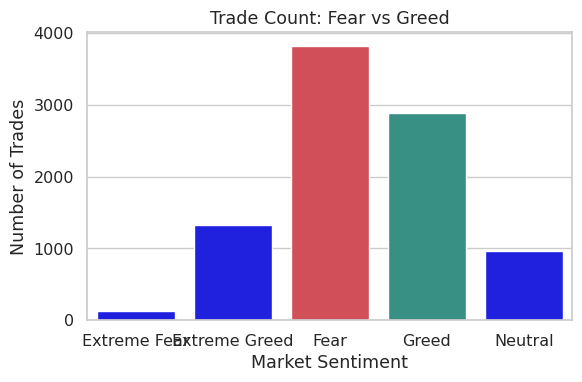

In [ ]:
# Trade Count: Fear vs Greed
if 'classification' in merged.columns:
    plt.figure(figsize=(6,4))
    order = sorted(merged['classification'].dropna().unique(), key=str)
    sns.countplot(x='classification', data=merged, order=order, palette=[palette[o] for o in order])
    plt.title("Trade Count: Fear vs Greed")
    plt.xlabel("Market Sentiment")
    plt.ylabel("Number of Trades")
    plt.tight_layout()
    plt.savefig('/content/outputs/trade_count.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping trade count plot: 'classification' not available.")


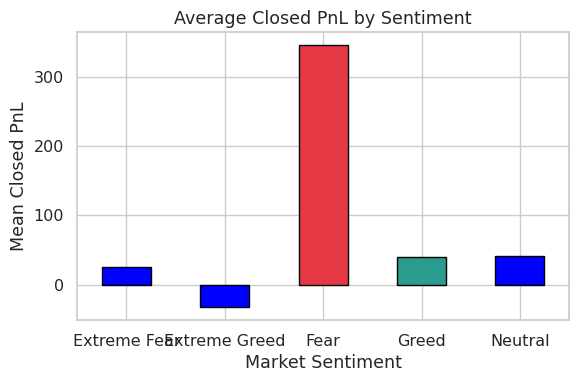

In [ ]:
# Average Profit under Each Sentiment
if 'closed_pnl' in merged.columns and 'classification' in merged.columns:
    avg_profit = merged.groupby('classification')['closed_pnl'].mean().sort_index()
    colors = [palette.get(idx, neutral_color) for idx in avg_profit.index]
    ax = avg_profit.plot(kind='bar', color=colors, edgecolor='black', figsize=(6,4))
    ax.set_title("Average Closed PnL by Sentiment")
    ax.set_ylabel("Mean Closed PnL")
    ax.set_xlabel("Market Sentiment")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('/content/outputs/avg_profit_sentiment.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping avg profit plot: needed 'closed_pnl' or 'classification'.")


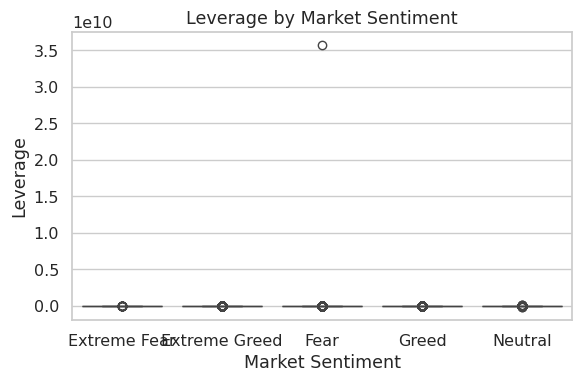

In [ ]:
# Plot leverage by sentiment
if 'leverage' in merged.columns and 'classification' in merged.columns:
    plt.figure(figsize=(6, 4))
    order = sorted(merged['classification'].dropna().unique(), key=str)
    sns.boxplot(
        x='classification', y='leverage', data=merged, order=order,
        palette=[palette[o] for o in order]
    )
    plt.title("Leverage by Market Sentiment")
    plt.xlabel("Market Sentiment")
    plt.ylabel("Leverage")
    plt.tight_layout()
    plt.savefig('/content/outputs/leverage_sentiment.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping leverage boxplot: 'leverage' or 'classification' missing.")



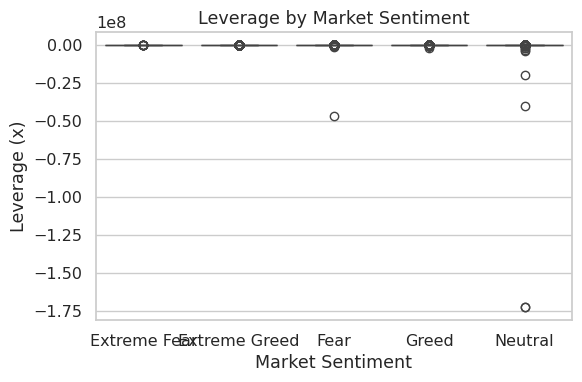

In [ ]:
# Filter extreme leverage values
merged = merged[merged["leverage"] < 100]

plt.figure(figsize=(6, 4))
order = sorted(merged["classification"].dropna().unique(), key=str)
palette = sns.color_palette("husl", len(order))

sns.boxplot(
    x="classification", y="leverage", data=merged,
    order=order, palette=palette
)

plt.title("Leverage by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Leverage (x)")
plt.tight_layout()
plt.savefig("/content/outputs/leverage_sentiment_filtered.png", dpi=300)
plt.show()

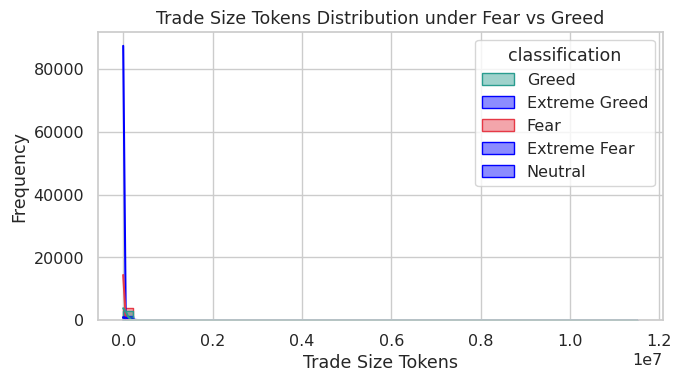

In [ ]:
# Trade Size Tokens distribution
if 'size_tokens' in merged.columns and 'classification' in merged.columns:
    plt.figure(figsize=(7,4))
    # Seaborn histplot with palette mapping via a loop if needed
    sns.histplot(data=merged, x='size_tokens', hue='classification', bins=50, kde=True,
                 element="step", alpha=0.45, stat='count',
                 palette=palette)
    plt.title("Trade Size Tokens Distribution under Fear vs Greed")
    plt.xlabel("Trade Size Tokens")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig('/content/outputs/trade_size_tokens_dist.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping trade size distribution: 'size_tokens' or 'classification' missing.")


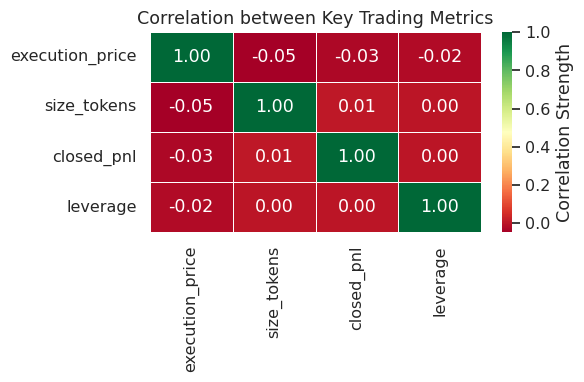

In [ ]:
# Correlation heatmap
candidate_nums = [c for c in ['execution_price', 'size_tokens', 'closed_pnl', 'leverage'] if c in merged.columns]
if len(candidate_nums) >= 2:
    corr = merged[candidate_nums].corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label':'Correlation Strength'}, cmap="RdYlGn")
    plt.title("Correlation between Key Trading Metrics")
    plt.tight_layout()
    plt.savefig('/content/outputs/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"Skipping heatmap: need >=2 numeric cols. Found: {candidate_nums}")
